In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50 ,DenseNet121, EfficientNetB7,VGG16
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam ,RMSprop
from keras.callbacks import ModelCheckpoint , ReduceLROnPlateau, EarlyStopping
import numpy as np

In [2]:
import tensorflow as tf

In [3]:
df = pd.read_csv('Pneumonia.csv')
df["category"] = df["category"].replace({0: 'Normal', 1: 'COVID-19', 2: 'Viral Pneumonia'})

In [4]:
df['category'].value_counts()

category
Viral Pneumonia    5972
Normal             1341
Name: count, dtype: int64

<Axes: xlabel='category'>

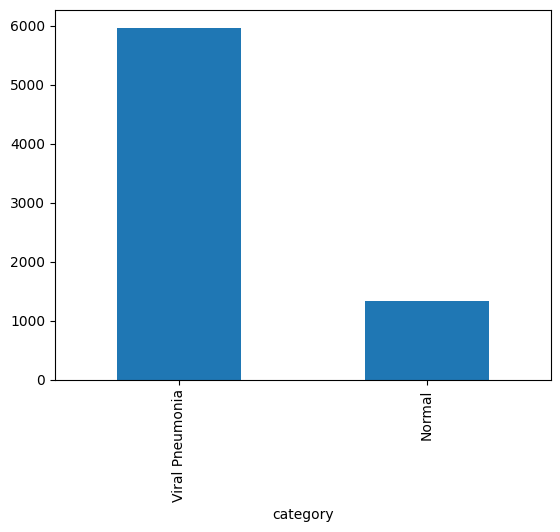

In [5]:
df['category'].value_counts().plot.bar()

In [8]:
class_counts = df['category'].value_counts()


In [10]:
from imblearn.over_sampling import RandomOverSampler

# Oversample the 'Normal' class to match the count of the majority class ('COVID-19')
oversample = RandomOverSampler(sampling_strategy={'Normal': class_counts['Viral Pneumonia']})
X_resampled, y_resampled = oversample.fit_resample(df.drop(columns=['category']), df['category'])

# Combine the resampled data into a DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=df.columns.drop('category'))
df_resampled['category'] = y_resampled

# Check the class distribution after oversampling
print(df_resampled['category'].value_counts())

category
Normal             5972
Viral Pneumonia    5972
Name: count, dtype: int64


In [14]:
df_resampled = df_resampled.sample(frac=1).reset_index(drop=True)

In [15]:
# Divide the dataset into training and validation sets
train_df, val_df = train_test_split(df_resampled, test_size=0.20, random_state=42)
validate_df,test_df = train_test_split(val_df, test_size=0.50, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [16]:
# Set your IMAGE_SIZE and other parameters
IMAGE_SIZE = (180,180)
batch_size = 16

In [17]:
#Create data generators
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
# train_datagen = ImageDataGenerator(
#     rotation_range=15,
#     rescale=1./255,
#     shear_range=0.1,
#     # zoom_range=0.2,
#     horizontal_flip=True,
    
#     brightness_range=[0.5, 1.5],
#     channel_shift_range=0.2,
#     vertical_flip=True,
#     preprocessing_function=lambda x: x + 0.01 * np.random.randn(*x.shape),
#     # random_rotation=30,
#     height_shift_range=0.1,
#     width_shift_range=0.1,
#     zoom_range=[0.8, 1.2],
#     # Exclude unsupported parameter
# )

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=None,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    directory=None,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
      batch_size=batch_size
)
   

Found 9555 validated image filenames belonging to 2 classes.
Found 1194 validated image filenames belonging to 2 classes.


In [18]:
class CustomLoss(tf.keras.losses.Loss):
    def __init__(self, reduction=tf.keras.losses.Reduction.AUTO, name="custom_loss"):
        super().__init__(reduction=reduction, name=name)

    def call(self, y_true, y_pred):
        return tf.reduce_mean(tf.square(y_true - y_pred))

In [19]:
custom_loss = CustomLoss()

In [20]:
previous_model = load_model('lung_ds.h5',custom_objects={'CustomLoss': CustomLoss})

In [21]:
previous_model.compile(optimizer=Adam(lr=0.001), loss=custom_loss, metrics=['accuracy'])

c:\Users\Iftek\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [22]:
previous_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 90, 90, 32)       128       
 ormalization)                                          

In [23]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'accuracy', 
                                            patience = 2, 
                                            verbose = 1, 
                                            factor = 0.5, 
                                            min_lr = 0.000001)
earlystop = EarlyStopping(
    monitor='val_loss',  # You can change this to another metric like 'val_accuracy'
    patience=10,  # Wait for 10 epochs to see if overfitting is resolved
    restore_best_weights=True,
    verbose=1
)
callbacks = [earlystop, learning_rate_reduction]

In [24]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [25]:
# Fit the model
epochs = 100

# history = model.fit_generator(
#     train_generator,
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=total_validate // batch_size,
#     steps_per_epoch=total_train // batch_size,
#     callbacks=callbacks
# )
history = previous_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate // batch_size,
    steps_per_epoch=total_train // batch_size,
    callbacks=callbacks
)

Epoch 1/100
597/597 [==============================] - 171s 275ms/step - loss: 0.1626 - accuracy: 0.7696 - val_loss: 0.1059 - val_accuracy: 0.8564 - lr: 0.0010
Epoch 2/100
597/597 [==============================] - 163s 273ms/step - loss: 0.0874 - accuracy: 0.8849 - val_loss: 0.0302 - val_accuracy: 0.9654 - lr: 0.0010
Epoch 3/100
597/597 [==============================] - 159s 267ms/step - loss: 0.0844 - accuracy: 0.8891 - val_loss: 0.0532 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 4/100
597/597 [==============================] - 161s 270ms/step - loss: 0.0674 - accuracy: 0.9124 - val_loss: 0.3524 - val_accuracy: 0.6047 - lr: 0.0010
Epoch 5/100
597/597 [==============================] - 161s 269ms/step - loss: 0.0540 - accuracy: 0.9303 - val_loss: 0.5009 - val_accuracy: 0.4983 - lr: 0.0010
Epoch 6/100
597/597 [==============================] - 162s 270ms/step - loss: 0.0535 - accuracy: 0.9307 - val_loss: 0.3114 - val_accuracy: 0.6706 - lr: 0.0010
Epoch 7/100
597/597 [===================

In [29]:
previous_model.save('pneumonia_ds.h5')

In [30]:
actual_epochs = len(history.history['loss'])

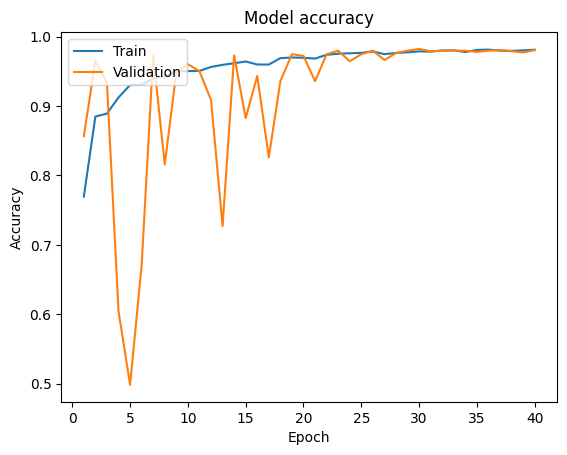

In [31]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
numEpochs = range(1,  actual_epochs + 1)
plt.plot(numEpochs,history.history['accuracy'])
plt.plot(numEpochs,history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

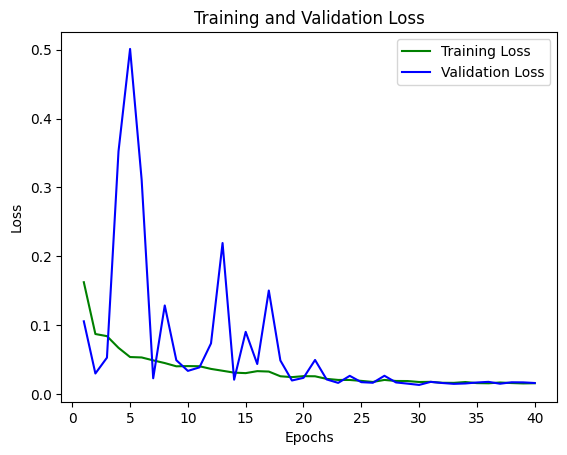

In [32]:
loss = history.history['loss']
val_loss = history.history['val_loss']
numEpochs = range(1,  actual_epochs + 1)
plt.plot( numEpochs,loss, 'g', label='Training Loss')
plt.plot(numEpochs,val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df

,filename,category
0,CLAHE\Pneumonia\Viral Pneumonia\images\CLAHE-p...,Viral Pneumonia
1,HE\Pneumonia\Viral Pneumonia\images\HE-person3...,Viral Pneumonia
2,CL+MEDIAN\Pneumonia\Viral Pneumonia\images\CLA...,Viral Pneumonia
3,Datasets\Pneumonia\Normal\images\NORMAL2-IM-05...,Normal
4,Datasets\Pneumonia\Normal\images\IM-0224-0001....,Normal
...,...,...
1190,Datasets\Pneumonia\Normal\images\NORMAL2-IM-12...,Normal
1191,Datasets\Pneumonia\Normal\images\NORMAL2-IM-05...,Normal
1192,CLAHE\Pneumonia\Viral Pneumonia\images\CLAHE-p...,Viral Pneumonia
1193,HE\Pneumonia\Viral Pneumonia\images\HE-person1...,Viral Pneumonia


In [34]:
nb_samples = test_df.shape[0]

In [35]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_dataframe(    
    test_df, 
    directory=None,
    x_col='filename',
    y_col='category',
    target_size = IMAGE_SIZE,
    
    class_mode='categorical',
    batch_size = batch_size,
    shuffle = False,
)

Found 1195 validated image filenames belonging to 2 classes.


In [36]:
predict = previous_model.predict_generator(test_generator, steps = np.ceil(nb_samples/batch_size))

C:\Users\Iftek\AppData\Local\Temp\ipykernel_13492\2406046781.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = previous_model.predict_generator(test_generator, steps = np.ceil(nb_samples/batch_size))


In [37]:
test_df['predict_category'] = np.argmax(predict, axis=-1)

In [38]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['predict_category'] = test_df['predict_category'].replace(label_map)

In [39]:
test_df.head()

,filename,category,predict_category
0,CLAHE\Pneumonia\Viral Pneumonia\images\CLAHE-p...,Viral Pneumonia,Viral Pneumonia
1,HE\Pneumonia\Viral Pneumonia\images\HE-person3...,Viral Pneumonia,Viral Pneumonia
2,CL+MEDIAN\Pneumonia\Viral Pneumonia\images\CLA...,Viral Pneumonia,Viral Pneumonia
3,Datasets\Pneumonia\Normal\images\NORMAL2-IM-05...,Normal,Normal
4,Datasets\Pneumonia\Normal\images\IM-0224-0001....,Normal,Normal


In [40]:
test_df['predict_category'] = test_df['predict_category'].replace({'Normal': 0, 'COVID-19': 1, 'Viral Pneumonia': 2})

<Axes: xlabel='category'>

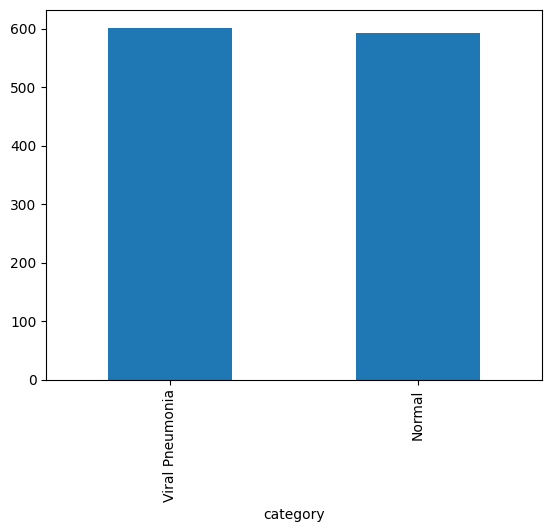

In [41]:
test_df['category'].value_counts().plot.bar()

In [42]:
sample_test = test_df
correctPredictions = 0

correctNormalPred = 0
correctCovidPred = 0
correctPneuPred = 0

totalNormalPred = 0
totalCovidPred = 0
totalPneuPred = 0

for index, row in sample_test.iterrows():
    
    filename = row['filename']
    prediction = row['predict_category']
    
    # img = load_img(filename, target_size=IMAGE_SIZE)
    path_parts = filename.split('\\')
    third_phrase = path_parts[2]
    # print(third_phrase)

    if 'Normal' in third_phrase:
        
        if prediction == 0:
            correctPredictions += 1
            correctNormalPred += 1
            
        totalNormalPred += 1
    
    if 'COVID' in third_phrase:
        
        if prediction == 1: 
            correctPredictions += 1
            correctCovidPred += 1
            
        totalCovidPred += 1
    
    if 'Viral Pneumonia' in third_phrase:
        
        if prediction == 2: 
            correctPredictions += 1
            correctPneuPred += 1
            
        totalPneuPred += 1
    

In [43]:
print('Model Accuracy:', "{:.2%}".format(correctPredictions / test_df.shape[0]))
print('Correct Predictions:', correctPredictions, 'Total Predictions:', test_df.shape[0])

print('\nNormal Predictions:', correctNormalPred, 'Accuracy', "{:.2%}".format(correctNormalPred /  totalNormalPred))
# print('COVID-19 Predictions:', correctCovidPred, 'Accuracy', "{:.2%}".format(correctCovidPred /  totalCovidPred))
print('Viral Pneumonia Predictions:', correctPneuPred, 'Accuracy', "{:.2%}".format(correctPneuPred / totalPneuPred))

Model Accuracy: 97.99%
Correct Predictions: 1171 Total Predictions: 1195

Normal Predictions: 584 Accuracy 98.48%
Viral Pneumonia Predictions: 587 Accuracy 97.51%


In [44]:
actual = []
pred = []

for row in test_df.iterrows():
    
    filename = row[1][0]
    # print(filename)
    path_parts = filename.split('\\')
    third_phrase = path_parts[2]
    if 'Normal' in third_phrase: actual.append(0)
    if 'COVID' in third_phrase: actual.append(1)
    if 'Viral Pneumonia' in third_phrase: actual.append(2)
    # print(f'Actual :{row[1][1]}')   
    # print(f'prediction :{row[1][2]}')   
    pred.append(row[1][2])

C:\Users\Iftek\AppData\Local\Temp\ipykernel_13492\4069215994.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filename = row[1][0]
C:\Users\Iftek\AppData\Local\Temp\ipykernel_13492\4069215994.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred.append(row[1][2])


In [45]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

In [46]:
print(classification_report(actual, pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       593
           2       0.98      0.98      0.98       602

    accuracy                           0.98      1195
   macro avg       0.98      0.98      0.98      1195
weighted avg       0.98      0.98      0.98      1195



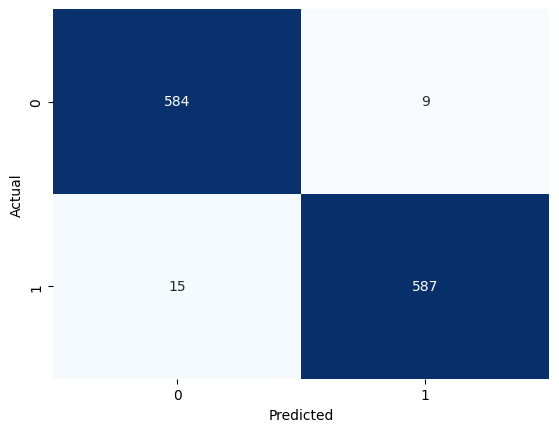

In [47]:
conf_matrix = confusion_matrix(actual, pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [48]:
# from keras.models import load_model
# previous_model.load_weights('pneumonia_ds.h5')

#Visualize The Model

In [49]:
# pip install tf-keras-vis


In [50]:
import tensorflow as tf
# from tensorflow.keras.models import load_model
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
import matplotlib.pyplot as plt
import cv2

# Load the model
model = load_model('pneumonia_ds.h5',custom_objects={'CustomLoss': CustomLoss})

# Load the image
image_path = 'Datasets\Pneumonia\Viral Pneumonia\images\person1_virus_12.jpeg'
image = cv2.imread(image_path)
image = cv2.resize(image, (200, 200))  # Resize if needed

# Define the saliency object
saliency = Saliency(model)



# Compute saliency map with the desired loss function

saliency_map = saliency(loss=custom_loss, seed_input=image)

# Normalize the saliency map
saliency_map = normalize(saliency_map)

# Visualize the original image and the saliency map
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[1].imshow(saliency_map.squeeze(), cmap='jet', alpha=0.6)
axes[1].imshow(image, alpha=0.4)  # Overlay the original image
axes[1].set_title('Saliency Map')
plt.show()


TypeError: __call__() got an unexpected keyword argument 'loss'